In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graph
from graph import LocMap, ConflictGraph, DistMatrixReconstruction
from collections import defaultdict
from labellines import labelLine, labelLines

from cvxpy import *

In [ ]:
def matrixInverse(inputM):
            e0 = inputM[0, 0]
            e1 = inputM[0, 1]
            e2 = inputM[1, 0]
            e3 = inputM[1, 1]
            m = 1.0 / (e0*e3 - e1*e2)
            matrix = np.array([[m*e3, m*(-e1)], [m*(-e2), m*e0]])
            return matrix
        
matrix = np.array([[2, 1], [3, 2]])
matrixInverse(matrix)

In [3]:
def construct_edges(node_num, p2p_graph, dist_matrix, num_edges):
    link_edges = defaultdict(dict)
    edge_no = 0
    
    labels = {}
    comm_edges_list = []

    for node_u in range(node_num):
        for node_v in range(node_u+1, node_num):
            if p2p_graph[node_u][node_v] == 1:
                link_edges[edge_no] = {'u':node_u, 'v':node_v, 'dist':dist_matrix[node_u][node_v]}
                edge_no += 1               

    assert (edge_no == num_edges)
    
    for edge_no in range(int(num_edges)):
        node_u = link_edges[edge_no]['u']
        node_v = link_edges[edge_no]['v']
        dist = link_edges[edge_no]['dist']
    
        comm_edges_list.append([node_u, node_v])
        labels[tuple([node_u, node_v])] = edge_no
    
    return link_edges, comm_edges_list, labels

def construct_conflict_edges(node_num, p2p_graph):
    
    conflict_edges_dict = defaultdict(dict)
    edge_no = 0

    conflict_edges_list = []

    for node_u in range(node_num):
        for node_v in range(node_u+1, node_num):
            if p2p_graph[node_u][node_v] == 1:
                conflict_edges_dict[edge_no] = {'u':node_u, 'v':node_v}
                edge_no += 1               
    
    for edge_no in range(len(conflict_edges_dict)):
        node_u = conflict_edges_dict[edge_no]['u']
        node_v = conflict_edges_dict[edge_no]['v']
    
        conflict_edges_list.append([node_u, node_v])
    
    return conflict_edges_dict, conflict_edges_list

In [188]:
node_num = 30

nodes_pos = graph.generate_nodes_pos(node_num, -20, 20)

complete_dist_graph = graph.generate_complete_dist_graph(nodes_pos)

# nodes_pos = np.array([[0,0], [2,0], [0, -1], [6, -1], [6, 3], [4,4]])

In [189]:
loc_pos = LocMap(nodes_pos, K=4)
loc_pos.HennenburgConstruction(random.randint(0, node_num))
loc_pos.ConstructEdgesK()
S = loc_pos.trilateration_ordering_check()


p2p_graph = loc_pos.get_graph()
dist_matrix = loc_pos.get_dist_matrix()

link_edges, comm_edges_list, labels = construct_edges(node_num, p2p_graph, dist_matrix, np.count_nonzero(p2p_graph == 1)/2)


In [250]:
dist_matrix = np.loadtxt("dist_matrix.csv", delimiter=",", dtype=np.double)
estimated_dist_matrix = np.loadtxt("measured_dist_matrix.csv", delimiter=",", dtype=np.double)

p2p_graph = np.zeros((dist_matrix.shape[0], dist_matrix.shape[1]))
assert (p2p_graph.shape[0] == p2p_graph.shape[1] == 30)
    
for i in range(p2p_graph.shape[0]):
    for j in range(p2p_graph.shape[1]):
        p2p_graph[i, j] = 1 if estimated_dist_matrix[i, j] != 0 else 0

In [253]:
print (np.allclose(p2p_graph, p2p_graph.T, rtol=10e-5, atol=10e-5))
print (np.count_nonzero(p2p_graph) / (node_num * (node_num-1)))

True
0.31724137931034485


In [19]:
def rmse(A,B):
    rmse = np.sqrt(np.mean(((A-B)**2)))
    return rmse

In [129]:
p2p_cpy

array([[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]], dtype=uint8)

In [209]:
np.count_nonzero(p2p_cpy) / (node_num * (node_num-1))

0.6850574712643678

In [223]:
p2p_cpy = p2p_graph.copy()

for i in range(p2p_graph.shape[0]):
    for j in range(i+1, p2p_graph.shape[1]):
        if p2p_cpy[i, j] == 0 and i != j:
            if random.random() >= 0.3:
                p2p_cpy[i, j] = 1
                p2p_cpy[j, i] = 1

In [224]:
noise = np.random.normal(0,2.5,(node_num, node_num))
noise_symm = (noise + noise.T)/2

np.allclose(noise_symm, noise_symm.T, rtol=10e-5, atol=10e-5)

True

In [225]:
masked_dist_matrix = np.multiply(p2p_cpy, dist_matrix)
noise_matrix = np.multiply(p2p_cpy, noise_symm)


estimated_dist_matrix = masked_dist_matrix + noise_matrix

In [226]:
rmse(masked_dist_matrix, estimated_dist_matrix)

1.5456636627595997

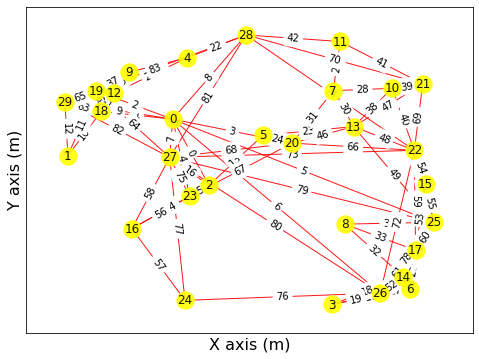

In [196]:
# node_idx = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
#             'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
#             'Y', 'Z', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AG', 'AI',
#             'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS',
#             'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC',
#             'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM',
#             'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW',
#             'BX', 'BY', 'BZ']

link_edges, comm_edges_list, labels = construct_edges(node_num, p2p_graph, dist_matrix, np.count_nonzero(p2p_graph == 1)/2)
node_idx = [x for x in range(node_num)]

G = nx.Graph()
G.add_edges_from(comm_edges_list)
pos = nodes_pos
# pos = {0: (0, 0), 1: (2, 0), 2: (0, -1), 3: (6, -1), 4: (6, 3), 5: (4, 4)} 
plt.figure(figsize=(8,6))

plt.xlabel('X axis (m)', fontsize=16)
plt.ylabel('Y axis (m)', fontsize=16)

nx.draw(
    G, pos, edge_color='red', width=1, linewidths=1,
    node_size=300, node_color='Yellow', alpha=0.9,
    labels={node: node_idx[node] for node in G.nodes()}
)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black'
)

plt.axis('on')
plt.show()

In [237]:
recon = DistMatrixReconstruction(estimated_dist_matrix, node_num)

D = recon.EDM_Completion(0.01, 0.003, 2000)

In [238]:
rmse(D, dist_matrix)

3.0197706865525835

In [ ]:
a = np.matmul(D, p2p_graph)

In [243]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", normalized_stress='auto')

node_locations = mds.fit_transform(D)
e = graph.mds_relative_to_absolute_scale(node_locations, [0, 1, 2], nodes_pos[:3])

In [244]:
e

array([[ -5.3679022 ,   8.01504045],
       [-17.04502871,   0.77354404],
       [ -4.55725197,  -2.02064931],
       [  4.41484112, -19.33710212],
       [ -4.47573285,  14.67131998],
       [  1.44934032,   1.93120239],
       [  7.53438845, -20.02555345],
       [  7.19132255,   6.54829858],
       [  6.72061535, -10.4730792 ],
       [ -9.97785318,  13.34794421],
       [ 12.66192231,   5.09143929],
       [  8.41814551,  12.16807374],
       [-11.86033491,  10.20602376],
       [  8.45682643,   1.34886587],
       [ 10.2872432 , -17.80130517],
       [ 14.22058622,  -5.86682747],
       [ -5.72026559,  -3.23329097],
       [ 12.26259623, -14.60432967],
       [-13.56778117,   7.63778345],
       [-14.148433  ,   9.8362505 ],
       [  3.41882549,   1.18766898],
       [ 15.74502909,   7.02827761],
       [ 13.60802446,  -1.3611307 ],
       [ -7.59429219,  -4.24169987],
       [-10.97359385, -16.03676847],
       [ 13.33669824, -11.81235574],
       [  8.11677494, -18.90414171],
 

In [245]:
nodes_pos

array([[ -6.71516659,   7.12567121],
       [-17.16283491,   1.94035446],
       [ -3.09218139,  -2.29809049],
       [  9.21151064, -19.30330187],
       [ -5.27446156,  15.88419301],
       [  2.28632852,   4.81615487],
       [ 16.95195222, -17.07174745],
       [  9.30323319,  11.19390755],
       [ 10.42385448,  -7.84461616],
       [-11.04772458,  13.84266803],
       [ 15.16044291,  11.53000595],
       [  9.98262077,  18.20956827],
       [-12.54045398,  10.85678043],
       [ 11.33730994,   6.07459314],
       [ 16.2829701 , -15.33485555],
       [ 18.50458823,  -2.15124709],
       [-10.78164357,  -8.47719922],
       [ 17.51574638, -11.56752559],
       [-13.82389833,   8.24013482],
       [-14.32682725,  11.1332827 ],
       [  5.19789124,   3.71101032],
       [ 18.22512838,  12.17343465],
       [ 17.38518349,   2.68644516],
       [ -5.00651096,  -3.88836074],
       [ -5.4819951 , -18.71024577],
       [ 19.33525531,  -7.57261664],
       [ 13.9840836 , -17.67169267],
 

In [246]:
rmse(e, nodes_pos)

3.3946563396629887

In [20]:
re_cp = graph.generate_complete_dist_graph(node_locations)
sa_cp = graph.generate_complete_dist_graph(nodes_pos)
e_cp = graph.generate_complete_dist_graph(e)

In [ ]:
e

In [ ]:
nodes_pos

In [ ]:
node_locations

In [21]:
rmse(e_cp, sa_cp)

0.0005536107831630041

In [ ]:
re_cp

In [ ]:
sa_cp

In [ ]:
def euclidean_dist(pos_a, pos_b):
    return math.dist(pos_a, pos_b)

def mds_relative_to_absolute_scale(estimated_coordinates, indices_of_anchors, anchors_true_coordinates):
    A = np.transpose(estimated_coordinates[indices_of_anchors,:])
    B = np.transpose(anchors_true_coordinates)
    estimated_coordinates = np.transpose(estimated_coordinates)

    assert (A.shape == B.shape)
    
    print ("A: \n{}".format(A))
    print ("B: \n{}".format(B))

    all_estimate_coordinates = estimated_coordinates
    num_of_points = estimated_coordinates.shape[1]
    
    print (num_of_points)
    
    def rigid_transform_3D(A,B):
        dimension, num_anchors = A.shape
        
        # find scale
        anchor_dist_A = np.zeros((num_anchors, num_anchors))
        anchor_dist_B = np.zeros((num_anchors, num_anchors))

        for i in range(num_anchors):
            for j in range(num_anchors):
                anchor_dist_A[i][j] = euclidean_dist(A[:, i], A[:, j])
                anchor_dist_B[i][j] = euclidean_dist(B[:, i], B[:, j])
        
        scale_matrix = np.divide(anchor_dist_B, anchor_dist_A, out=np.zeros_like(anchor_dist_A), where=anchor_dist_B!=0)
        total_n = 0
        cnt = 0
        for i in range(0, scale_matrix.shape[1]):
            for j in range(i+1, scale_matrix.shape[1]):
                total_n += scale_matrix[i, j]
                cnt += 1
        scale = total_n / cnt
        A = scale*A

        # find rotation
        centroid_A = np.expand_dims(np.mean(A, axis=1), axis=1)
        centroid_B = np.expand_dims(np.mean(B, axis=1), axis=1)
        
        diff_A = A - np.tile(centroid_A, (1, num_anchors))
        diff_B = B - np.tile(centroid_B, (1, num_anchors))

        H = diff_A @ np.transpose(diff_B)

        u, _, v = np.linalg.svd(H)

        rotation = v.T @ u.T

        # find translation
        translation = np.matmul(-rotation, centroid_A) + centroid_B

        return rotation, translation, scale

    rotation, translation, scale = rigid_transform_3D(A, B)
    
    # print ("Rotation: \n{},\nTranslation: \n{},\nScale: {}".format(rotation, translation, scale))

    estimated_coord_mds = np.matmul(rotation, (scale*all_estimate_coordinates)) + np.tile(translation, (1, num_of_points))

    return np.transpose(estimated_coord_mds)

In [ ]:
e = mds_relative_to_absolute_scale(node_locations, [0, 1, 2], nodes_pos[:3])


print ()
print (nodes_pos)
print (e)


In [ ]:
node_idx = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
            'Y', 'Z', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AG', 'AI',
            'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS',
            'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC',
            'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM',
            'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW',
            'BX', 'BY', 'BZ']

G = nx.Graph()
G.add_edges_from(comm_edges_list)
pos = nodes_pos
# pos = {0: (0, 0), 1: (2, 0), 2: (0, -1), 3: (6, -1), 4: (6, 3), 5: (4, 4)} 
plt.figure(figsize=(8,6))

plt.xlabel('X axis (m)', fontsize=16)
plt.ylabel('Y axis (m)', fontsize=16)

nx.draw(
    G, pos, edge_color='red', width=1, linewidths=1,
    node_size=300, node_color='Yellow', alpha=0.9,
    labels={node: node_idx[node] for node in G.nodes()}
)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black'
)

plt.axis('on')
plt.show()

In [ ]:
node_idx = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
            'Y', 'Z', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AG', 'AI',
            'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS',
            'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC',
            'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM',
            'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW',
            'BX', 'BY', 'BZ']

G = nx.Graph()
G.add_edges_from(comm_edges_list)
pos = e
# pos = {0: (0, 0), 1: (2, 0), 2: (0, -1), 3: (6, -1), 4: (6, 3), 5: (4, 4)} 
plt.figure(figsize=(8,6))

plt.xlabel('X axis (m)', fontsize=16)
plt.ylabel('Y axis (m)', fontsize=16)

nx.draw(
    G, pos, edge_color='red', width=1, linewidths=1,
    node_size=300, node_color='Yellow', alpha=0.9,
    labels={node: node_idx[node] for node in G.nodes()}
)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black'
)

plt.axis('on')
plt.show()

In [ ]:
conf_graph_obj = ConflictGraph(node_num, nodes_pos, dist_matrix, p2p_graph, link_edges)

conf_graph_obj.construct_conflict_graph()
conf_graph_obj.construct_independent_sets_by_edges()

conf_graph = conf_graph_obj.get_conflict_graph()
independent_sets = conf_graph_obj.get_independent_sets()

print (conf_graph)

_, conf_links = construct_conflict_edges(len(link_edges), conf_graph)

In [ ]:
print (conf_links)

In [ ]:
print (independent_sets)

In [ ]:
import matplotlib as mpl

G = nx.Graph()
G.add_edges_from(conf_links)
pos = nx.spring_layout(G)
plt.figure(figsize=(8,6))

cmap = plt.cm.plasma

nx.draw(
    G, pos, edge_color='black', width=2, linewidths=2,
    node_size=300, node_color='pink', alpha=0.9, arrowstyle="->",
    arrowsize=25,
    labels={node: node for node in G.nodes()}
)

# nodes = nx.draw_networkx_nodes(G, pos, node_size=300, node_color="indigo", alpha=)
# edges = nx.draw_networkx_edges(
#     G,
#     pos,
#     node_size=3,
#     arrowstyle="->",
#     arrowsize=10,
#     edge_color='black',
#     edge_cmap=cmap,
#     width=2,
# )
# set alpha value for each edge


ax = plt.gca()
ax.set_axis_off()
plt.show()

In [ ]:
relative_dist_graph = mds.matrix_mask(dist_matrix, p2p_graph)

# m = np.max(relative_dist_graph)
# relative_dist_graph /= m
# relative_dist_graph[relative_dist_graph == 0] = np.nan

In [ ]:
A = p2p_graph + np.eye(5)

In [ ]:
np.linalg.matrix_rank(relative_dist_graph)

In [ ]:
np.linalg.eigvals(relative_dist_graph)

In [ ]:
def rmse(A,B):
    rmse = np.sqrt(np.mean(((A-B)**2)))
    print("RMSE: %.2f" %rmse)
    return rmse

In [ ]:
from matrix_completion import svt_solve, nuclear_norm_solve, pmf_solve, biased_mf_solve

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

a = imp.fit_transform(relative_dist_graph)

In [ ]:
rmse(dist_matrix, a)

In [ ]:
X = Variable(dist_matrix.shape)
obj = Minimize(norm(X*PM1, 'fro') + norm((PU1.T)*X, 'fro')) # norm frobenius: information from graphs
constraints = [multiply(mat_mask, X) == multiply(mat_mask, np.array(UM))]
prob = Problem(obj, constraints)
prob.solve(solver=SCS)